<a href="https://colab.research.google.com/github/Kamii114/Fashion-Recommender-System-using-Transfer-Learning/blob/main/ML_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Machine Learning Course Project
# Topic:Fashion Recommender System using Transfer Learning
# By: Kamand Kalashi

# The Libraries we need are:

In [ ]:
# Import the necessary libraries

# PIL library is used for working with images
from PIL import Image

# The "os" module provides a way of using operating system dependent functionality
import os

# Matplotlib is a plotting library for the Python programming language
import matplotlib.pyplot as plt

# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices
import numpy as np

# Import the VGG16 model and related functions from Keras
from keras.applications import vgg16
from keras.utils.image_utils import load_img, img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

# Import the cosine_similarity function from scikit-learn
from sklearn.metrics.pairwise import cosine_similarity

# Pandas is a fast, powerful, flexible, and easy-to-use open-source data analysis and data manipulation library for Python
import pandas as pd

# Importing the Kaggle dataset into colab so we don't have to upload it!

In [ ]:
# Installing Kaggle package in colab:
# !pip install -q kaggle

In [ ]:
# Uploading our personal API token from Kaggle:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamandkalashi","key":"41651cb7cb2c563c9f911578086b2482"}'}

In [ ]:
#Create a Kaggle folder
! mkdir -p ~/.kaggle

In [ ]:
# copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/

In [ ]:
# permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# to list all datasets in kaggle
! kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          32422        879  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                               6KB  2023-05-28 18:26:48           3914        112  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           6054        128  1.0              
mohithsairamreddy/salary-data 

In [ ]:
# Downloading the the chosen dataset that we want to work on: (In our case it's the Fashion product images-small version)
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

 99% 562M/565M [00:19<00:00, 33.1MB/s]
100% 565M/565M [00:19<00:00, 29.8MB/s]


In [ ]:
# unzipping our dataset:
!unzip fashion-product-images-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/images/58150.jpg  
  inflating: myntradataset/imag

### Getting images and setting height and weight. Note that here VGG16 Transfer learning model is being used and the architecture of the model informs that the first input layer accepts input in the shape of (none, 224,224,3). Therefore, the shape of the images is 224,224.

In [ ]:
# Set the path where the images are located
imgs_path = "/content/images/"

# Define the width and height of the images for the model
imgs_model_width, imgs_model_height = 224, 224

# Specify the number of closest images to retrieve
nb_closest_images = 5

In [ ]:
# Create a list of file paths for the images in the specified directory
files = [imgs_path + x for x in os.listdir(imgs_path) if "jpg" in x]
# Print the total number of images found
print("Total number of images:",len(files))

Total number of images: 44441


###For reducing compilation time of the algorithm, we reduce the data to 3000 images or the system crashes!


In [ ]:
# Reduce the number of files to 3000 to avoid crashes during compilation
files=files[0:3000]

### Testing feature extraction with one image

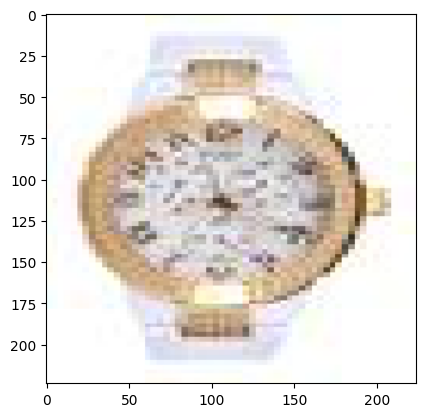

Image loaded successfully!


In [ ]:
#Load and display an example image for testing feature extraction
original = load_img(files[70], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("Image loaded successfully!")

In [ ]:
# Load the VGG16 model
vgg_model = vgg16.VGG16(weights='imagenet')

# Remove the last layers to obtain features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# Print the layers of the CNN
feat_extractor.summary()

553467096/553467096 [==============================] - 25s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

### convert the image / images into batch format. expand_dims will add an extra dimension to the data at a particular axis. we want the input matrix to the network to be of the form (batchsize, height, width, channels),thus we add the extra dimension to the axis 0.

In [ ]:
# Convert the loaded image to a numpy array
numpy_image = img_to_array(original)

# Convert the image(s) into batch format and add an extra dimension for the network input
image_batch = np.expand_dims(numpy_image, axis=0)
print('Image Batch size', image_batch.shape)

# Prepare the image for the VGG model by preprocessing the input
processed_image = preprocess_input(image_batch.copy())

Image Batch size (1, 224, 224, 3)


In [ ]:
# Extract features from the image using the feature extractor model
img_features = feat_extractor.predict(processed_image)

print("Features successfully extracted for one image!")
print("Number of image features:",img_features.size)
img_features

1/1 [==============================] - 8s 8s/step
Features successfully extracted for one image!
Number of image features: 4096


array([[1.0981888, 3.6530747, 0.7078765, ..., 3.7249432, 0.       ,
        0.       ]], dtype=float32)

# Because the algorithm works for one image, it should work for a batch of images, let us try!

In [ ]:
# Import and process multiple images for feature extraction
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)

    importedImages.append(image_batch)

images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [ ]:
# Extract features from the images using the feature extractor model
imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

94/94 [==============================] - 19s 147ms/step
features successfully extracted!


(3000, 4096)

In [ ]:
# Calculate cosine similarities between the image features
cosSimilarities = cosine_similarity(imgs_features)

# Store the cosine similarities in a pandas dataframe
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

,/content/images/27062.jpg,/content/images/4300.jpg,/content/images/53450.jpg,/content/images/29748.jpg,/content/images/44742.jpg,/content/images/25051.jpg,/content/images/45025.jpg,/content/images/35542.jpg,/content/images/27881.jpg,/content/images/28146.jpg,...,/content/images/18477.jpg,/content/images/18346.jpg,/content/images/37132.jpg,/content/images/40457.jpg,/content/images/53695.jpg,/content/images/13054.jpg,/content/images/48742.jpg,/content/images/51982.jpg,/content/images/34933.jpg,/content/images/41347.jpg
/content/images/27062.jpg,1.000000,0.226364,0.339547,0.411559,0.457689,0.376259,0.424845,0.453415,0.381400,0.411750,...,0.537707,0.404303,0.310751,0.351717,0.574546,0.398546,0.394342,0.325221,0.298328,0.256122
/content/images/4300.jpg,0.226364,1.000000,0.251154,0.301886,0.277808,0.353934,0.444302,0.320795,0.618964,0.381590,...,0.303841,0.434320,0.622071,0.233338,0.464551,0.299783,0.317003,0.670107,0.535791,0.413921
/content/images/53450.jpg,0.339547,0.251154,1.000000,0.371819,0.504795,0.316019,0.562178,0.535230,0.322794,0.333897,...,0.671351,0.423533,0.329089,0.411747,0.339187,0.383885,0.577341,0.293966,0.322976,0.211891
/content/images/29748.jpg,0.411559,0.301886,0.371819,1.000000,0.456638,0.415411,0.598136,0.451627,0.470385,0.391695,...,0.442230,0.329809,0.479339,0.284879,0.448989,0.734312,0.331451,0.441101,0.487703,0.375634
/content/images/44742.jpg,0.457689,0.277808,0.504795,0.456638,1.000000,0.381503,0.504540,0.547579,0.390432,0.425250,...,0.573403,0.414866,0.396724,0.503965,0.392855,0.411139,0.506396,0.345146,0.372540,0.273273


In [ ]:
# Function to retrieve the most similar products given an image

def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

-----------------------------------------------------------------------
original product:


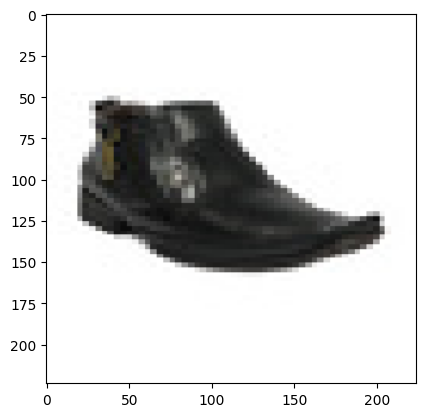

-----------------------------------------------------------------------
most similar products:


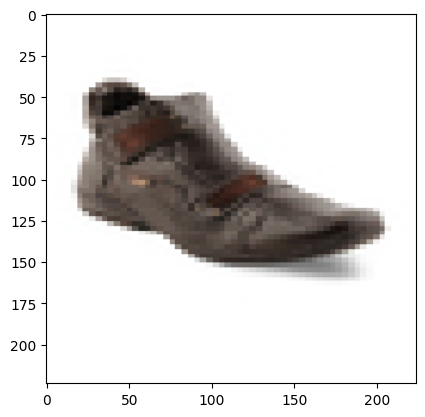

similarity score :  0.8086157


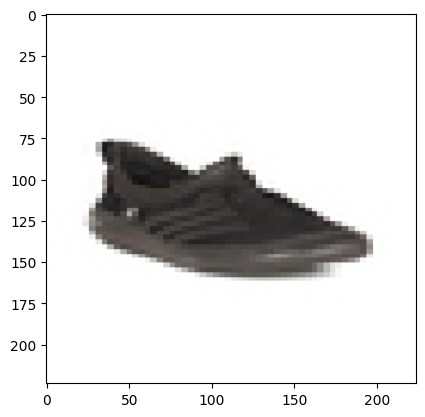

similarity score :  0.79371077


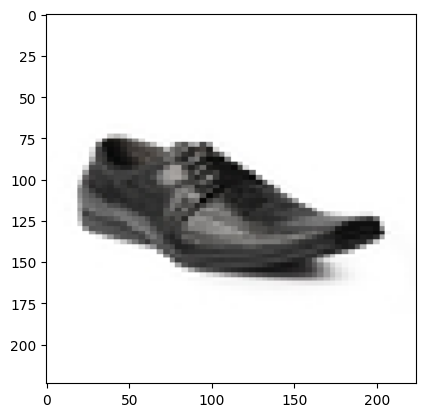

similarity score :  0.7923548


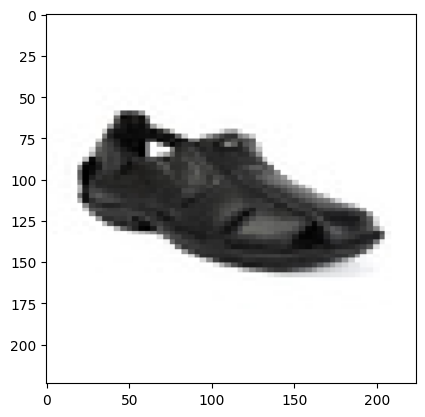

similarity score :  0.7827107


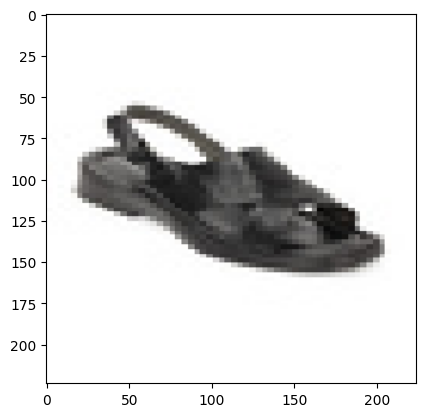

similarity score :  0.7824471


In [ ]:
# Retrieve the most similar products for a given image
retrieve_most_similar_products(files[80])

-----------------------------------------------------------------------
original product:


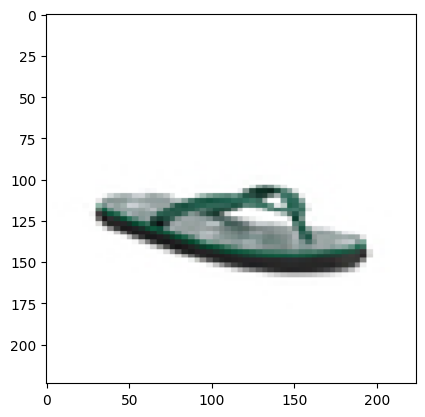

-----------------------------------------------------------------------
most similar products:


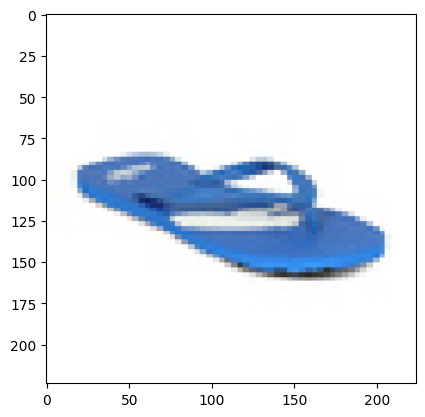

similarity score :  0.8396566


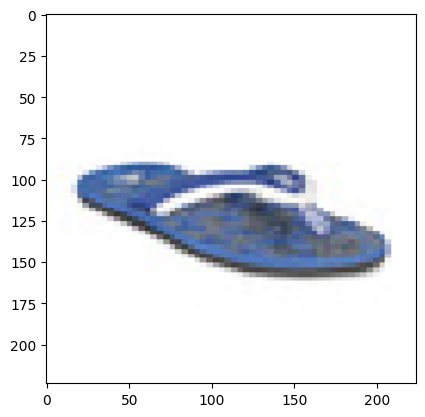

similarity score :  0.839128


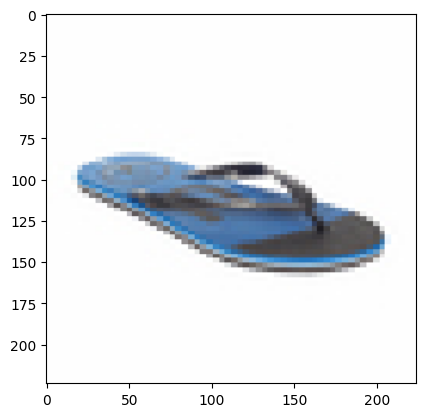

similarity score :  0.8379235


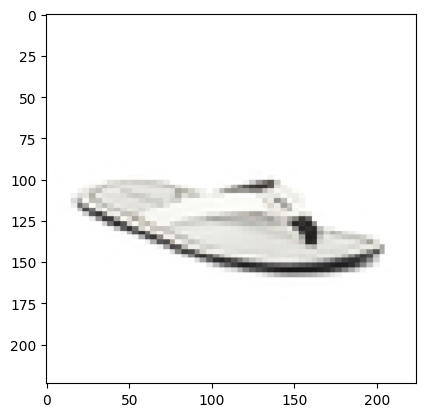

similarity score :  0.81956404


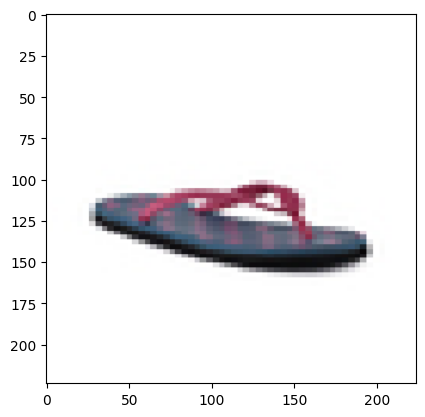

similarity score :  0.8153049


In [ ]:
retrieve_most_similar_products(files[2])

-----------------------------------------------------------------------
original product:


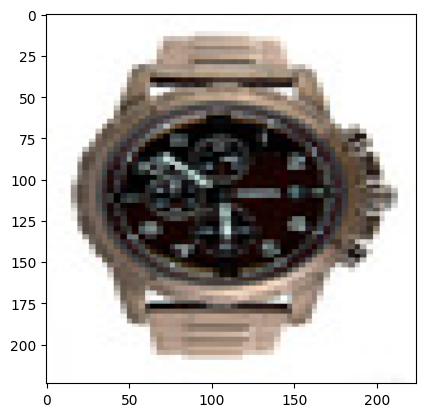

-----------------------------------------------------------------------
most similar products:


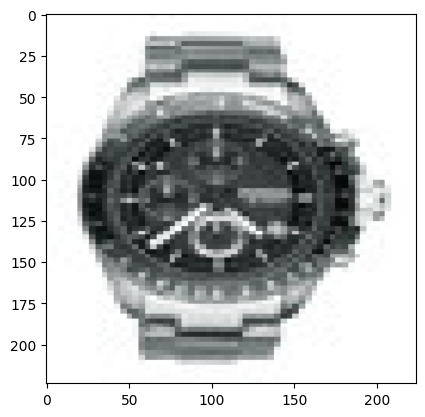

similarity score :  0.86577475


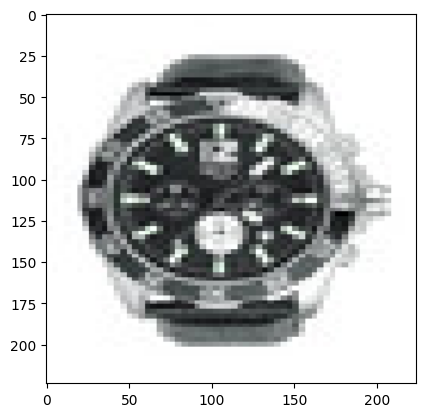

similarity score :  0.8382465


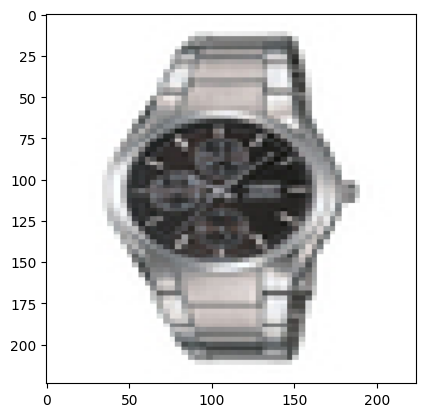

similarity score :  0.8364945


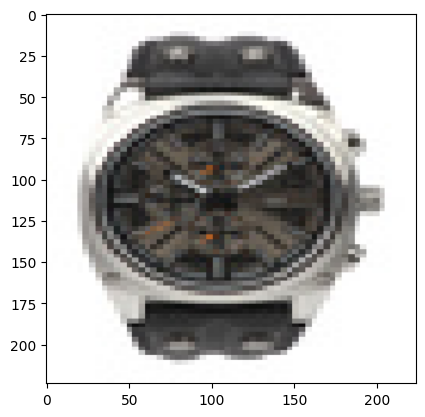

similarity score :  0.82342124


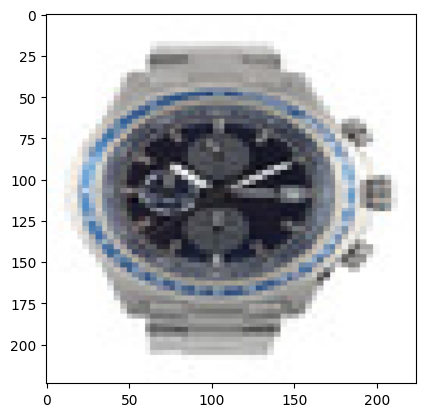

similarity score :  0.82270616


In [ ]:
retrieve_most_similar_products(files[3])

-----------------------------------------------------------------------
original product:


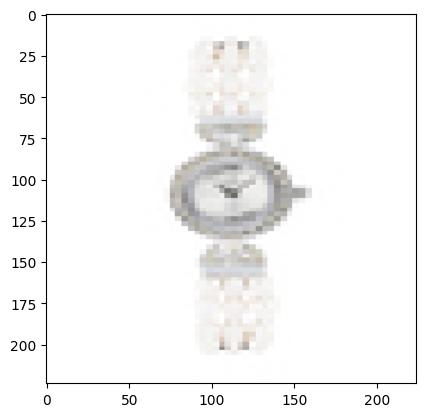

-----------------------------------------------------------------------
most similar products:


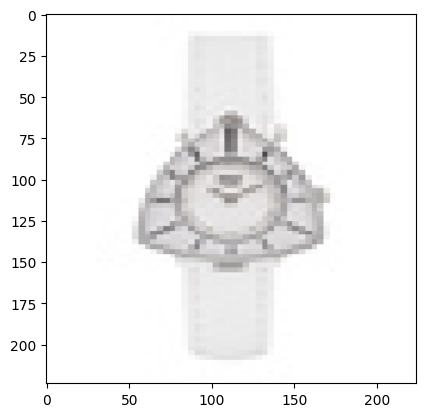

similarity score :  0.84256166


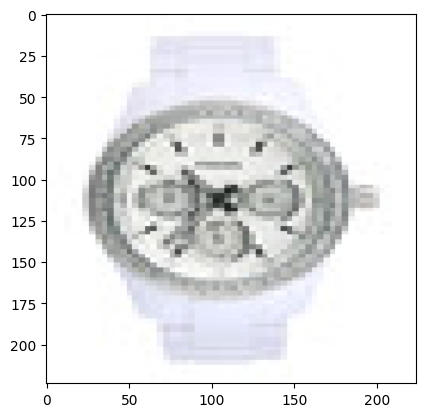

similarity score :  0.8146919


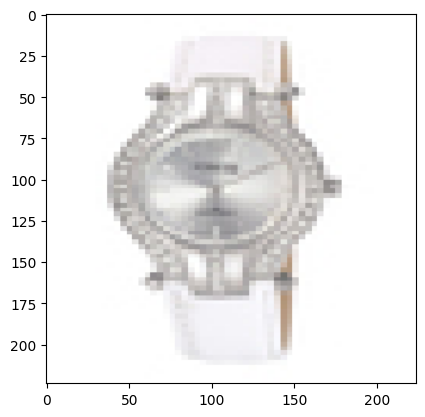

similarity score :  0.79736155


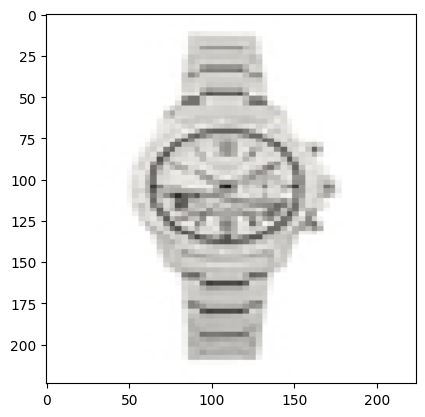

similarity score :  0.78420645


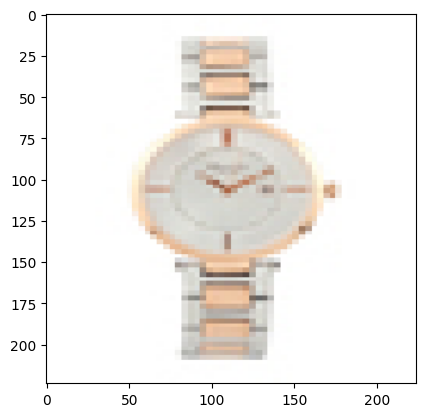

similarity score :  0.778485


In [ ]:
retrieve_most_similar_products(files[6])

-----------------------------------------------------------------------
original product:


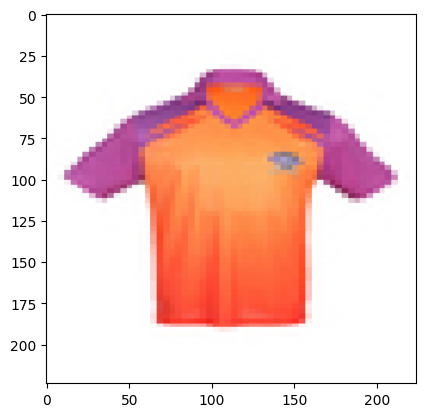

-----------------------------------------------------------------------
most similar products:


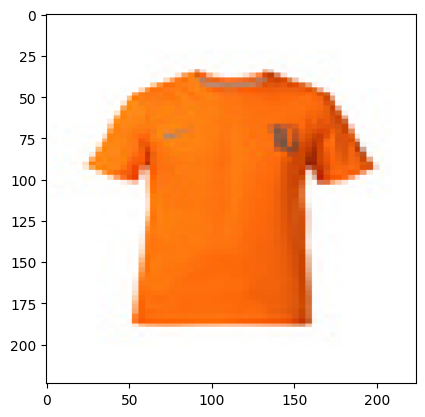

similarity score :  0.825467


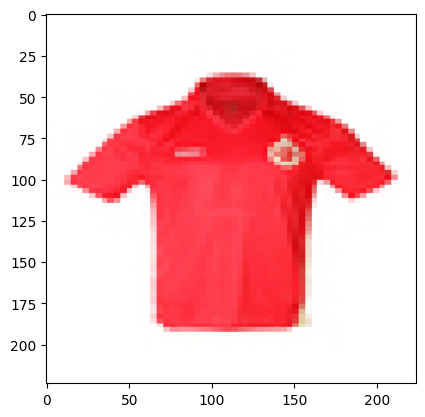

similarity score :  0.81079346


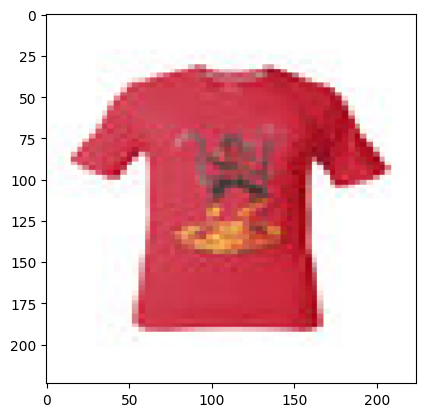

similarity score :  0.78933364


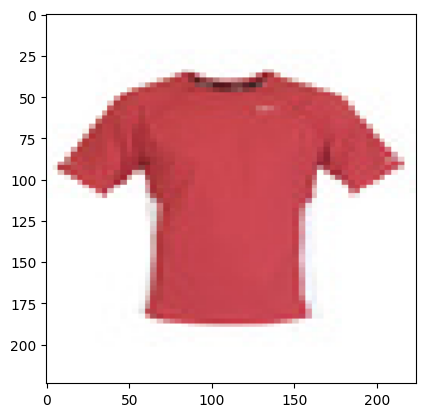

similarity score :  0.78624535


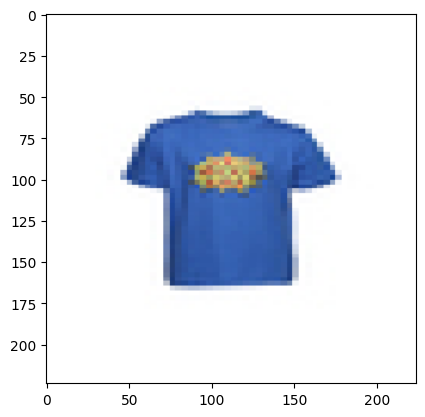

similarity score :  0.77198374


In [ ]:
retrieve_most_similar_products(files[56])

-----------------------------------------------------------------------
original product:


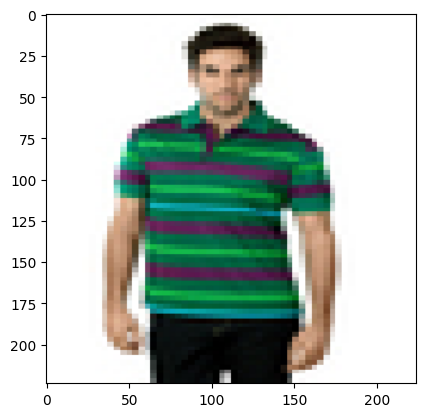

-----------------------------------------------------------------------
most similar products:


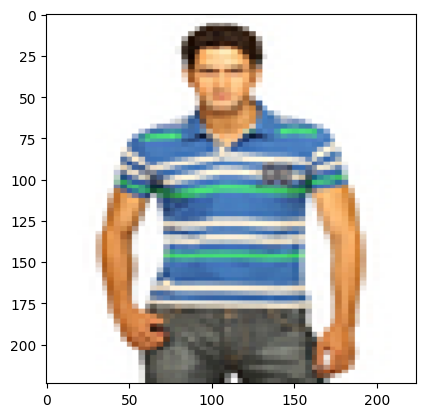

similarity score :  0.80102164


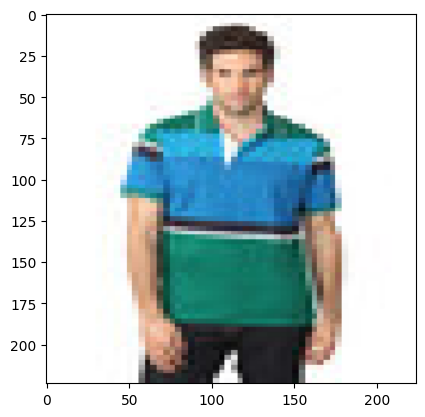

similarity score :  0.7993292


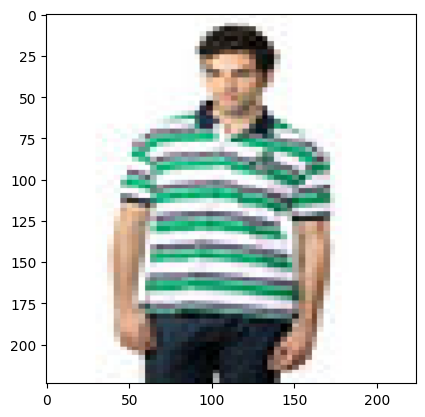

similarity score :  0.78235364


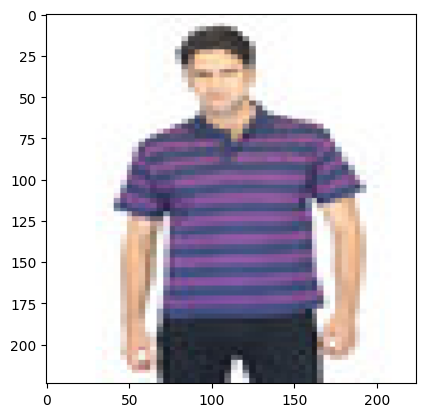

similarity score :  0.7784983


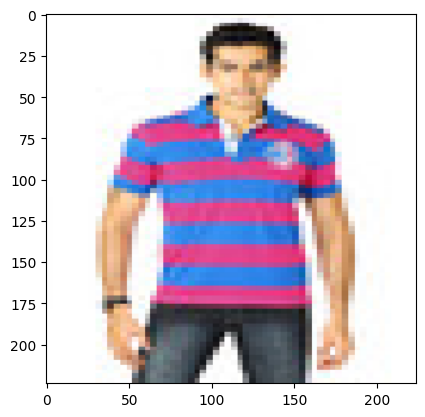

similarity score :  0.7640422


In [ ]:
retrieve_most_similar_products(files[77])

### Thence, the algorithm is providing pretty good recommendations, even with a small dataset of 3000 images.

